In [1]:
import pandas as pd
import pickle as pkl
import os


def get_target_df(ann_folder):
    rows = {}
    for filename in os.listdir(ann_folder):
        with open(os.path.join(ann_folder, filename), 'rb') as f:
            d = pkl.load(f)
            instance_data = next(iter(d.values()))
            anns = instance_data['diagnosis_anns']
            anns = {(k, question): v2 for k, v in anns.items() for question, v2 in v.items()}
            del instance_data['diagnosis_anns']
            instance_data.update(anns)
            rows.update(d)
    return pd.DataFrame(rows).transpose().sort_index()

from collections import defaultdict
def get_full_target_df(ann_dirs):
    dfs = defaultdict(lambda : pd.DataFrame([]))
    for ann_dir in ann_dirs:
        for split in os.listdir(ann_dir):
            for annotator in os.listdir(os.path.join(ann_dir, split)):
                df = get_target_df(os.path.join(ann_dir, split, annotator))
                df['annotator'] = [annotator] * len(df)
                dfs[split] = pd.concat([dfs[split], df])
    return dict(dfs)

In [2]:
# WE DO NOT USE ANY OF THESE INSTANCES IN THE REST OF THE EVAL BECAUSE
# WE ALTERED THE MODEL AFTER STARTING ANNOTATIONS
dfs1 = get_full_target_df(['/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_9-7-23/target_annotations'])
dfs1['val2']

,instance_idx,split,"(pneumonia, is_confident_diagnosis)","(pneumonia, could_be_identified_earlier)","(cancer, is_confident_diagnosis)","(cancer, could_be_identified_earlier)","(pulmonary edema, is_confident_diagnosis)","(pulmonary edema, could_be_identified_earlier)",annotator
0,11,val2,No,NaN,NaN,NaN,NaN,NaN,Andrea_Young
1,12,val2,Yes,Yes,NaN,NaN,NaN,NaN,Andrea_Young
2,16,val2,NaN,NaN,Yes,Yes,NaN,NaN,Andrea_Young
3,17,val2,No,NaN,NaN,NaN,Yes,No,Andrea_Young
4,22,val2,Yes,Yes,Yes,Yes,NaN,NaN,Andrea_Young
5,22,val2,No,NaN,Yes,Yes,NaN,NaN,Andrea_Young
6,34,val2,No,NaN,NaN,NaN,Yes,No,Andrea_Young
7,35,val2,NaN,NaN,Yes,Yes,NaN,NaN,Andrea_Young
8,40,val2,NaN,NaN,NaN,NaN,Yes,No,Andrea_Young


In [3]:
dfs = get_full_target_df([
    # '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_9-7-23/target_annotations', # before changing target extraction
    '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_9-29-23/target_annotations',
    # '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_11-3-23/target_annotations',
    # '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_11-9-23/target_annotations',
    '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_11-14-23/target_annotations',
    # '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_11-16-23/target_annotations',
    # '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_11-17-23/target_annotations',
    '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_11-20-23/target_annotations',
    # '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_11-21-23/target_annotations',
    # '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_11-30-23/target_annotations',
    # '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_12-11-23/target_annotations',
    '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_12-14-23/target_annotations',
    ])
df = dfs['val2']
for condition in ['pulmonary edema', 'pneumonia', 'cancer']:
    df[(condition, 'classification')] = df.apply(lambda r:
        '' if r[(condition, 'is_confident_diagnosis')] != r[(condition, 'is_confident_diagnosis')] else \
        'Incorrect' if r[(condition, 'is_confident_diagnosis')] == 'No' else \
        'Correct and On Time' if r[(condition, 'could_be_identified_earlier')] == 'No' else \
        'Correct but Late', axis=1)
df

,instance_idx,split,"(pulmonary edema, report_idx)","(pulmonary edema, is_confident_diagnosis)","(pulmonary edema, could_be_identified_earlier)","(pneumonia, report_idx)","(pneumonia, is_confident_diagnosis)","(pneumonia, could_be_identified_earlier)","(cancer, report_idx)","(cancer, is_confident_diagnosis)","(cancer, could_be_identified_earlier)",annotator,"(pulmonary edema, classification)","(pneumonia, classification)","(cancer, classification)"
0,49,val2,35,Yes,No,57,Yes,Yes,NaN,NaN,NaN,Andrea,Correct and On Time,Correct but Late,
1,51,val2,4,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,Andrea,Correct but Late,,
2,53,val2,3,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,Andrea,Correct and On Time,,
3,54,val2,NaN,NaN,NaN,NaN,NaN,NaN,24,Yes,Yes,Andrea,,,Correct but Late
4,58,val2,7,No,NaN,7,No,NaN,NaN,NaN,NaN,Andrea,Incorrect,Incorrect,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,239,val2,4,Yes,No,65,No,NaN,NaN,NaN,NaN,Geoff,Correct and On Time,Incorrect,
23,246,val2,64,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,Geoff,Correct and On Time,,
24,248,val2,NaN,NaN,NaN,NaN,NaN,NaN,26,Yes,Yes,Geoff,,,Correct but Late
25,249,val2,33,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,Geoff,Correct but Late,,


In [4]:
print(len(df))
df_dropped = df.drop_duplicates(['instance_idx'], keep='first', ignore_index=True)
print(len(df_dropped))

71
52


In [5]:
from collections import Counter
Counter(df_dropped.annotator)

Counter({'Andrea': 15, 'Lucy': 1, 'William': 4, 'Geoff': 32})

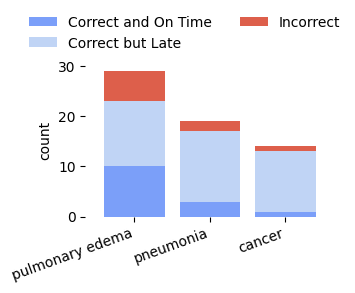

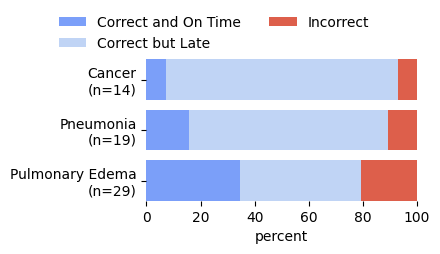

In [6]:
import seaborn as sns
from collections import Counter
import numpy as np
rows = []
for condition in ['pulmonary edema', 'pneumonia', 'cancer']:
    y = df_dropped[(condition, 'classification')]
    y = y[y != '']
    y = Counter(y)
    rows.append({
        'condition': condition,
    })
    rows[-1].update(y)
df_temp = pd.DataFrame(rows).set_index('condition')[['Correct and On Time', 'Correct but Late', 'Incorrect']]
counts = df_temp.sum(axis=1).to_dict()
# df_temp
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=(3.5, 3.5))
chart = df_temp.plot(kind='bar', stacked=True, color=sns.color_palette("coolwarm", 4)[:2] + [sns.color_palette("coolwarm", 7)[6]], width=.8, ax=axs)
chart.set_xlabel('')
chart.set_ylabel('count')
axis=chart.axis()
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.legend(
    ncols=2,
    loc="upper center",
    bbox_to_anchor=(0.4, 1.4), frameon=False)
axs.set_xticklabels(
    axs.get_xticklabels(),
    horizontalalignment='left',
    rotation=20,
    ha='right',
    # weight='bold',
    # fontsize=10,
)
fig.tight_layout()
fig, axs = plt.subplots(1, 1, figsize=(4.5, 3))
new_df_temp = {}
for x in df_temp.columns:
    new_df_temp[x] = df_temp.apply(lambda r: r[x] * 100 / sum([r[x2] for x2 in df_temp.columns]), axis=1)
df_temp = pd.DataFrame(new_df_temp).rename(index={k: f'{k.title()}\n(n={v})' for k, v in counts.items()})
chart = df_temp.plot(kind='barh', stacked=True, color=sns.color_palette("coolwarm", 4)[:2] + [sns.color_palette("coolwarm", 7)[6]], width=.8, ax=axs)
chart.set_ylabel('')
chart.set_xlabel('percent')
chart.set_xlim(0, 100)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.set_ylim(-.4, 2.4)
axis=chart.axis()
axs.legend(
    ncols=2,
    loc="upper center",
    bbox_to_anchor=(0.25, 1.4), frameon=False)
fig.tight_layout()
fig.savefig('figures/synthetic_labels_precision.pdf')
# mean_data = df_temp.groupby('model').agg({'max_usefulness': np.mean})
# sns.scatterplot(data=mean_data, x='model', y='max_usefulness', ax=chart, color='black', marker='s', linewidth=2)
# for i, row in mean_data.iterrows():
#     chart.annotate('%.1f' % row.max_usefulness, xy=(i, row.max_usefulness + .2), horizontalalignment='center', color='black', fontsize=14)
# chart.axis(axis)


In [7]:
instances_with_at_least_4_annotators = set([
    instance_idx for instance_idx in set(df.instance_idx) if len(set(df[df.instance_idx == instance_idx].annotator)) >= 4
])
instances_with_at_least_4_annotators

{49, 51, 53, 54, 58, 62}

In [8]:
df_for_agreement = df[df.instance_idx.isin(instances_with_at_least_4_annotators)]
annotators = list(set(df_for_agreement.annotator))
df_for_agreement_concat = []
for annotator in annotators:
    df_for_agreement_concat.append(
        df_for_agreement[df_for_agreement.annotator == annotator].drop(
            columns=['annotator']).set_index(['split', 'instance_idx']))
    df_for_agreement_concat[-1] = df_for_agreement_concat[-1].rename(
        columns={
            c: f'{c}_{annotator}'
            for c in df_for_agreement_concat[-1].columns
        })
df_for_agreement = pd.concat(df_for_agreement_concat, axis=1)
df_for_agreement

('pulmonary edema', 'report_idx')_William   
split instance_idx                                             
val2  49                                                  35  \
      51                                                   4   
      53                                                   3   
      54                                                 NaN   
      58                                                   7   
      62                                                  31   

                   ('pulmonary edema', 'is_confident_diagnosis')_William   
split instance_idx                                                         
val2  49                                                          Yes     \
      51                                                          Yes      
      53                                                          Yes      
      54                                                          NaN      
      58                                                          Yes      
      62                                                           No      

                   ('pulmonary edema', 'could_be_identified_earlier')_William   
split instance_idx                                                              
val2  49                                                           No          \
      51                                                          Yes           
      53                                                           No           
      54                                                          NaN           
      58                                                          Yes           
      62                                                          NaN           

                   ('pneumonia', 'report_idx')_William   
split instance_idx                                       
val2  49                                            57  \
      51                                           NaN   
      53                                           NaN   
      54                                           NaN   
      58                                             7   
      62                                           NaN   

                   ('pneumonia', 'is_confident_diagnosis')_William   
split instance_idx                                                   
val2  49                                                       Yes  \
      51                                                       NaN   
      53                                                       NaN   
      54                                                       NaN   
      58                                                        No   
      62                                                       NaN   

                   ('pneumonia', 'could_be_identified_earlier')_William   
split instance_idx                                                        
val2  49                                                          Yes    \
      51                                                          NaN     
      53                                                          NaN     
      54                                                          NaN     
      58                                                          NaN     
      62                                                          NaN     

                   ('cancer', 'report_idx')_William   
split instance_idx                                    
val2  49                                        NaN  \
      51                                        NaN   
      53                                        NaN   
      54                                         24   
      58                                        NaN   
      62                                        NaN   

                   ('cancer', 'is_confident_diagnosis')_William   
split instance_idx                                                
val2  49                                      

In [9]:
df_for_agreement_final = []
for d in ['pulmonary edema', 'pneumonia', 'cancer']:
    x = df_for_agreement[[str((d, 'classification')) + f'_{a}' for a in annotators]].rename(
        columns={str((d, 'classification')) + f'_{a}': a for a in annotators}
    ).reset_index()
    x = x[x[annotators[0]] != '']
    x['Diagnosis'] = [d] * len(x)
    df_for_agreement_final.append(x)
df_for_agreement_final = pd.concat(df_for_agreement_final)
df_for_agreement_final

,split,instance_idx,William,Lucy,Geoff,Andrea,Diagnosis
0,val2,49,Correct and On Time,Correct and On Time,Correct and On Time,Correct and On Time,pulmonary edema
1,val2,51,Correct but Late,Correct but Late,Correct but Late,Correct but Late,pulmonary edema
2,val2,53,Correct and On Time,Correct but Late,Correct but Late,Correct and On Time,pulmonary edema
4,val2,58,Correct but Late,Incorrect,Incorrect,Incorrect,pulmonary edema
5,val2,62,Incorrect,Incorrect,Incorrect,Incorrect,pulmonary edema
0,val2,49,Correct but Late,Correct and On Time,Correct but Late,Correct but Late,pneumonia
4,val2,58,Incorrect,Incorrect,Incorrect,Incorrect,pneumonia
3,val2,54,Correct but Late,Correct but Late,Correct but Late,Correct but Late,cancer


In [10]:
df_for_agreement_final_simplified = df_for_agreement_final.copy()
for a in annotators:
    df_for_agreement_final_simplified[a] = df_for_agreement_final_simplified[a].apply(
        lambda x: 'Correct' if x.startswith('Correct') else x)
df_for_agreement_final_simplified

,split,instance_idx,William,Lucy,Geoff,Andrea,Diagnosis
0,val2,49,Correct,Correct,Correct,Correct,pulmonary edema
1,val2,51,Correct,Correct,Correct,Correct,pulmonary edema
2,val2,53,Correct,Correct,Correct,Correct,pulmonary edema
4,val2,58,Correct,Incorrect,Incorrect,Incorrect,pulmonary edema
5,val2,62,Incorrect,Incorrect,Incorrect,Incorrect,pulmonary edema
0,val2,49,Correct,Correct,Correct,Correct,pneumonia
4,val2,58,Incorrect,Incorrect,Incorrect,Incorrect,pneumonia
3,val2,54,Correct,Correct,Correct,Correct,cancer


In [11]:
from statsmodels.stats.inter_rater import aggregate_raters, fleiss_kappa
x, cats = aggregate_raters(df_for_agreement_final[
    ['Lucy', 'William', 'Geoff', 'Andrea']].to_numpy())
x

array([[4, 0, 0],
       [0, 4, 0],
       [2, 2, 0],
       [0, 1, 3],
       [0, 0, 4],
       [1, 3, 0],
       [0, 0, 4],
       [0, 4, 0]])

In [12]:
fleiss_kappa(x, method='fleiss')

0.6757852077001013

In [13]:
x_simplified, cats_simplified = aggregate_raters(df_for_agreement_final_simplified[
    ['Lucy', 'William', 'Geoff', 'Andrea']].to_numpy())
x_simplified

array([[4, 0],
       [4, 0],
       [4, 0],
       [1, 3],
       [0, 4],
       [4, 0],
       [0, 4],
       [4, 0]])

In [14]:
fleiss_kappa(x_simplified, method='fleiss')

0.8614718614718615